In [29]:
import QuantLib as ql
import numpy as np
import scipy.stats as stats
import scipy.optimize as spo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import sample
import sklearn.neural_network as sknn
import matplotlib.pyplot as plt
import time
from scipy.integrate import *
import cmath as cpx
import math as m
from sklearn.metrics import mean_squared_error
from copy import deepcopy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [30]:
def MakeUniformRandParams(ArrayMin,ArrayMax,nRand):
    if (len(ArrayMin)!=len(ArrayMax)):
        raise Exception('ArrayMax and ArrayMin must have the same size')
    else:
        nParams = len(ArrayMin)
        rand_seq = ql.UniformRandomSequenceGenerator(nParams*nRand,ql.UniformRandomGenerator())
        X = rand_seq.nextSequence().value()
        #X = [ArrayMin[j%nParams]+(ArrayMax[j%nParams]-ArrayMin[j%nParams])*X[j] for j in range(nParams*nRand)]
        res = np.zeros((nRand,nParams))
        LocalMax = 0
        res__ = 0
        res_ = 0
        for i in range(nRand):
            for j in range(nParams):
                AdjMax = ArrayMax[j]
                if j==2:
                    AdjMax = XiFellerAdjust(res__,res_,ArrayMax[j])
                res[i,j]=ArrayMin[j]+(AdjMax-ArrayMin[j])*X[i*nParams+j]
                res__ = res_
                res_ = res[i,j]
        #res = np.reshape(X,(nRand,nParams))
        return res

def CountNoFellerCondition(X):
    k=0
    for j in range(len(X)):
        if (X[j,2]>XiFellerMax(X[j,0],X[j,1])):
            k=k+1
    return k

def XiFellerMax(kappa,theta):
    return m.sqrt(2*kappa*theta)

def XiFellerAdjust(kappa,theta,xi_init):
    if (xi_init>XiFellerMax(kappa,theta)):
        return XiFellerMax(kappa,theta)
    return xi_init
    
ArrayMin = [0.1, 0.1,  0.01, -0.999, 0.1]
ArrayMax = [1.5, 1.5,  0.75,  0.999, 1.5]
nRand = 100000
start = time.time()
res=MakeUniformRandParams(ArrayMin,ArrayMax,nRand)
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')
print('No Feller Condition ' + str(CountNoFellerCondition(res)))

Total computation time = 0.76s
No Feller Condition 0


In [31]:
# GLOBAL CONFIG #
AsOfDate = ql.Date(15,10,2018)
ql.Settings.instance().evaluationDate = AsOfDate
DayCount = ql.Actual365Fixed()
Calendar = ql.UnitedStates()

In [68]:
# EUROPEAN OPTION CONFIG #
MaturityDates = []
strikes = []
exercises = []
payoffs = []
option_type = ql.Option.Call
ms = [1,2,3,6,0,6,0,0,0,0]
ys = [0,0,0,0,1,1,2,3,4,5]
for k in range(len(ms)):
    if (10+ms[k]>12):
        ys_sup=1
    else:
        ys_sup=0
    MaturityDates.append(ql.Date(15,(10+ms[k]-1)%12+1,2018+ys[k]+ys_sup))
    exercises.append(ql.EuropeanExercise(MaturityDates[k]))
for k in range(7):
        strikes.append(70+k*10)
        #payoffs.append(ql.PlainVanillaPayoff(option_type, strikes[k]))
print(MaturityDates)
print(strikes)
EuropeanOptions = []
for K in range(len(strikes)):
    for T in range(len(MaturityDates)):
        EuropeanOptions.append(ql.VanillaOption(ql.PlainVanillaPayoff(option_type,100-(100-strikes[K])*m.sqrt((MaturityDates[T]-AsOfDate)/365)), exercises[T]))
#print(EuropeanOptions)

[Date(15,11,2018), Date(15,12,2018), Date(15,1,2019), Date(15,4,2019), Date(15,10,2019), Date(15,4,2020), Date(15,10,2020), Date(15,10,2021), Date(15,10,2022), Date(15,10,2023)]
[70, 80, 90, 100, 110, 120, 130]


In [69]:
def d1(S0, K, r, sigma, T):
    m = S0/(K*np.exp(-r*T))
    return np.log(m)*(1/(sigma*np.sqrt(T)))+sigma*np.sqrt(T)/2

def d2(S0, K, r, sigma, T):
    return d1(S0,K,r,sigma,T)-sigma*np.sqrt(T)
 
def BS_CallPrice(S0,K,r,sigma,T):
    if T==0:
        return np.maximum(S0-K,0)
    else:
        return S0*stats.norm.cdf(d1(S0,K,r,sigma,T))-K*np.exp(-r*T)*stats.norm.cdf(d2(S0,K,r,sigma,T))

def Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho):
    alpha = complex(-omega**2 / 2, -omega / 2)
    beta = complex(kappa,-rho*ksi*omega)
    gamma = ksi**2 / 2
    h = (beta**2-4*alpha*gamma)**0.5
    r_m = (beta-h) / ksi**2
    r_p = (beta+h) / ksi**2
    g = r_m / r_p
    C = kappa*(r_m*t-2*cpx.log((1-g*cpx.exp(-h*t))/(1-g))/ksi**2)
    D = r_m*((1-cpx.exp(-h*t))/(1-g*cpx.exp(-h*t)))
    return cpx.exp(complex(C*theta+D*v0,omega*np.log(S0*np.exp(r*t))))

def RPI1_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega-complex(0,1),S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega*Heston_CharacteristicFunctionLogPrice(t,-complex(0,1),S0,v0,r,kappa,theta,ksi,rho))
    return (num / denom).real
def RPI2_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega)
    return (num / denom).real
def Heston_CallPrice(K,S0,r,T,v0,kappa,theta,ksi,rho):
    Pi_1 = 1/2+1/np.pi*quad(RPI1_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    Pi_2 = 1/2+1/np.pi*quad(RPI2_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    return S0*Pi_1-K*np.exp(-r*T)*Pi_2

def IVol(Mkt,S0,K,r,T,vol0=0.1):
    def f(vol,Mkt_,S0_,K_,r_,T_,type_): return (BS_CallPrice(S0_,K_,r_,vol,T_)-Mkt)**2
    return spo.minimize(f,vol0,args=(Mkt,S0,K,r,T,type),tol=1.0e-10).x

In [81]:
#OLD
Expiries = [0.0833,0.1667,0.25,0.5,1,1.5,2,3,4,5]
BaseStrikes = [70,80,90,100,110,120,130]
Strikes = []
for K in range(len(BaseStrikes)):
    for T in range(len(Expiries)):
        Strikes.append(100-(100-BaseStrikes[K])*m.sqrt(Expiries[T])) 

In [71]:
# MARKET DATA
r=ql.SimpleQuote(0.01)
r_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(r),DayCount)
q=ql.SimpleQuote(0.0)
q_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(q),DayCount)
s0=ql.SimpleQuote(100)

# BLACK SCHOLES ENGINE ONLY USED FOR COMPUTING IMPLIED VOLATILITIES
vol_bs = ql.SimpleQuote(0.10)
vol_bs_ts = ql.BlackConstantVol(0,Calendar,ql.QuoteHandle(vol_bs),DayCount)
BSProcess = ql.BlackScholesMertonProcess(ql.QuoteHandle(s0),ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                               ql.BlackVolTermStructureHandle(vol_bs_ts))

# HESTON ENGINE
v0 = 0.01
kappa=0.5
theta=0.01
sigma=0.0001
rho=-0.5
HestonParams = [theta,kappa,sigma,rho,v0]
relTolerance=0.01
maxEval=10000
HestonProcess = ql.HestonProcess(ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                                 ql.QuoteHandle(s0),v0,kappa,theta,sigma,rho)
HestonModel = ql.HestonModel(HestonProcess)
HestonEngine = ql.AnalyticHestonEngine(HestonModel,relTolerance,maxEval)
for i in range(len(EuropeanOptions)):
    EuropeanOptions[i].setPricingEngine(HestonEngine)

In [135]:
# GENERATE DATAS
nRand = 100000
start = time.time()
MinParamsValues = [0.1,0.1,0.1,-0.999,0.1]
MaxParamsValues = [2.5,0.6,1.5,-0.10,0.6]
local_start = 0
local_end = 0
ArrParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)
intermediary = time.time()

#npv = np.zeros(nRand)
#iv = np.zeros(nRand)
#for i in range(nRand):
#    HestonModel.setParams([ArrParams[i][k] for k in range(len(MinParamsValues))])
#    npv[i] = EuropeanOption.NPV()
#    iv[i] = EuropeanOption.impliedVolatility(npv[i],BSProcess,1.0e-4,200,1.0e-8,10)
#end = time.time()
#print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
#print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
#print('Total computation time = ' + str(round(end-start,2)) + 's')
#X = np.zeros((nRand*len(Strikes),len(ArrParams[0])+2))
npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([ArrParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
end = time.time()
print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
print('Total computation time = ' + str(round(end-start,2)) + 's')

Random params simulation time = 0.5s
Prices computation time = 476.44s
Total computation time = 476.95s


In [58]:
HestonPrice = EuropeanOptions[j].NPV()
time_=ql.Date(15,11,2018)-AsOfDate
print(time_)
print(EuropeanOptions[j])

31
<QuantLib.QuantLib.VanillaOption; proxy of <Swig Object of type 'VanillaOptionPtr *' at 0x00000263EC97A2D0> >


In [60]:
print(HestonPrice)
print('K = ' + str(strikes[j%len(strikes)]))
print('T = ' + str(MaturityDates[int(j/len(strikes))]))
print(ArrParams[i])
new_vol = 100
vol_bs.setValue(new_vol)
EuropeanOptions[j].setPricingEngine(ql.AnalyticEuropeanEngine(BSProcess))
print(EuropeanOptions[j].NPV())

97.3865967715769
K = 70
T = October 15th, 2028
[ 0.87791359  0.57905022  0.85163063 -0.6712743   0.47793902]
90.47630508934425


In [37]:
def ann_layers_neurones(layer, neurone):
    hidden_layer_sizes = (neurone, )
    if layer == 1.0: return hidden_layer_sizes
    elif layer > 1.0:
        for i in range(layer-1):
            hidden_layer_sizes += (neurone,)
        return hidden_layer_sizes

nLayersMin = 3
nLayersMax = 5
nLayersStep = 1
nNeuronesMin = 30
nNeuronesMax = 60
nNeuronesStep = 5
hidden_layers_sizes_vect = []
i_ = 0
for i in range(nNeuronesMin,nNeuronesMax+1,nNeuronesStep):
    j_ = 0
    for j in range(nLayersMin,nLayersMax+1,nLayersStep):
        hidden_layers_sizes_vect.append(ann_layers_neurones(j,i))
        j_ += 1
    i_ += 1
print(hidden_layers_sizes_vect)

[(30, 30, 30), (30, 30, 30, 30), (30, 30, 30, 30, 30), (35, 35, 35), (35, 35, 35, 35), (35, 35, 35, 35, 35), (40, 40, 40), (40, 40, 40, 40), (40, 40, 40, 40, 40), (45, 45, 45), (45, 45, 45, 45), (45, 45, 45, 45, 45), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50), (55, 55, 55), (55, 55, 55, 55), (55, 55, 55, 55, 55), (60, 60, 60), (60, 60, 60, 60), (60, 60, 60, 60, 60)]


In [136]:
start = time.time()
n = nRand
ann = sknn.MLPRegressor(hidden_layer_sizes=(30,30,30))
array_train_rel_error = np.zeros((n,len(EuropeanOptions)))
array_test_rel_error = np.zeros((n,len(EuropeanOptions)))
array_train_abs_error = np.zeros((n,len(EuropeanOptions)))
array_test_abs_error = np.zeros((n,len(EuropeanOptions)))
index = sample(range(0,nRand),n)
X=np.zeros((n,len(ArrParams[0])))
for k in range(len(ArrParams[0])):        
    X[:,k]=[ArrParams[j,k] for j in index]
Y=[iv[j,:] for j in index]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ANN FIT

mse_optim = 1000
ann_optim = deepcopy(ann)
for current_archi in hidden_layers_sizes_vect:
    ann.set_params(hidden_layer_sizes=current_archi)
    ann.fit(X_train,Y_train)
    train_prediction=ann.predict(X_train)
    mse=mean_squared_error(Y_train,train_prediction)
    print('current archi ' + str(current_archi) + ' ; mse = ' + str(mse))
    if (mse<mse_optim):
        mse_optim=mse
        print('I am optimal')
        ann_optim=deepcopy(ann)
        test_prediction=ann.predict(X_test)
        for i in range(max(len(X_train),len(X_test))):
            for j in range(len(EuropeanOptions)):
                if (i < len(X_train)):
                    array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                    array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
                if (i < len(X_test)):
                    array_test_abs_error[i,j]=(test_prediction[i,j]-Y_test[i][j])*100
                    array_test_rel_error[i,j]=(test_prediction[i,j]/Y_test[i][j]-1)*100
        #array_train_error=[[ann.predict(X_train)[i,j]-Y_train[i][j] for j in range(len(EuropeanOptions))] for i in range(n)]
        #array_test_error=[[ann.predict(X_test)[i,j]-Y_test[i][j] for j in range(len(EuropeanOptions))] for i in range(n)]
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')

current archi (30, 30, 30) ; mse = 9.699341485286756e-05
I am optimal
current archi (30, 30, 30, 30) ; mse = 0.00014448045760372745
current archi (30, 30, 30, 30, 30) ; mse = 0.00010347433035359606
current archi (35, 35, 35) ; mse = 0.00010750726995334964
current archi (35, 35, 35, 35) ; mse = 0.00010560237891833477
current archi (35, 35, 35, 35, 35) ; mse = 8.89008383036152e-05
I am optimal
current archi (40, 40, 40) ; mse = 8.829545913473824e-05
I am optimal
current archi (40, 40, 40, 40) ; mse = 8.509542072575816e-05
I am optimal
current archi (40, 40, 40, 40, 40) ; mse = 7.082188486546036e-05
I am optimal
current archi (45, 45, 45) ; mse = 7.737127639263769e-05
current archi (45, 45, 45, 45) ; mse = 7.400900192113933e-05
current archi (45, 45, 45, 45, 45) ; mse = 6.254624831761844e-05
I am optimal
current archi (50, 50, 50) ; mse = 7.767392377825928e-05
current archi (50, 50, 50, 50) ; mse = 6.732838474552364e-05
current archi (50, 50, 50, 50, 50) ; mse = 4.5914905059592e-05
I am o

In [155]:
def EvalANN(params,ann_,output_): return mean_squared_error(output_,ann_.predict([params]))
def InvertANN(ann,mkt,scaler,params0=[0.5,0.25,0.3,-0.5,0.25]):
    Sparams0 = scaler.transform([params0])
    return spo.minimize(EvalANN,Sparams0,args=(ann,mkt),tol=1.0e-8)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertANN(ann_optim,iv,scaler)
end = time.time()
ann_iv = ann_optim.predict([res.x])
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(scaler.inverse_transform(res.x)))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('ANN Calibrated IV Surface : ' + str(ann_iv[0]*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv-ann_iv)[0]*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 0.32s
The optimal set of params is [ 2.58524778  0.31592106  1.48136758 -0.73677433  0.31346273]
The initial set of params is [ 2.39331901  0.34036567  1.22612328 -0.8891384   0.30476804]
The standard deviation on the surface is 0.6190361715450251%


Initial IV Surface : [ 61.68346355  64.6345848   67.05577314  72.45452389  81.49847166
  86.03341786  90.78232433  98.85653438 106.80550928 116.57775806
  60.18916199  62.63982426  64.69725451  69.43303243  76.4778182
  81.70773538  85.87978619  92.44755312  98.0164035  103.56620217
  58.71225975  60.68284387  62.41110242  66.58428459  73.08919019
  77.98993995  81.88003393  87.85307898  92.63972197  97.03068498
  57.25257714  58.74764123  60.1619228   63.84959482  70.00135159
  74.7580296   78.54083359  84.3092813   88.80079696  92.72695646
  55.80364688  56.83763562  57.95667699  61.22872822  67.15927283
  71.87760567  75.65192404  81.39002283  85.84786324  89.5133618
  54.36788525  54.93085476  55.81552252

In [75]:
def HestonIV(HestonModel_,Options_,BSProcess_):
    LocIV = np.zeros(len(Options_))
    for j in range(len(Options_)):
        npv = max(Options_[j].NPV(),np.random.uniform(0,0.01))
        LocIV[j] = Options_[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
    return LocIV

def EvalHestonIV(params,HestonModel_,Options_,BSProcess_,RefIV_):
    HestonModel_.setParams([params[k] for k in range(len(params))])
    LocIV = HestonIV(HestonModel_,Options_,BSProcess_)
    return mean_squared_error(RefIV_,[LocIV])
        
def InvertHestonIV(HestonModel,RefIV,Options,BSProcess,params0=[0.5,0.25,0.3,-0.5,0.25]):
    return spo.minimize(EvalHestonIV,params0,args=(HestonModel,Options,BSProcess,RefIV),tol=1.0e-10)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    #for j in range(len(EuropeanOptions)):
    #    npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
    #    iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertHestonIV(HestonModel,iv,EuropeanOptions,BSProcess)
end = time.time()
#print([res.x[k] for k in range(len(res.x))])
HestonModel.setParams([res.x[k] for k in range(len(res.x))])
opt_iv = HestonIV(HestonModel,EuropeanOptions,BSProcess)
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(res.x))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('Calibrated IV Surface : ' + str(opt_iv*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv[0]-opt_iv)*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 7.38s
The optimal set of params is [ 2.37828581  0.32349167  0.44693459 -0.5400369   0.2277765 ]
The initial set of params is [ 2.37828653  0.32349195  0.44694135 -0.54002797  0.22777647]
The standard deviation on the surface is 4.732841824085933e-06%


Initial IV Surface : [ 52.797339    56.07841249  59.04807311  66.32496157  77.77672568
  86.751922    94.29082935 107.13925949 119.50650804 134.86438071
  52.19593213  55.27639403  58.10189426  65.12052721  76.22830727
  84.87680192  92.02404804 103.70490681 113.8596244  124.3224013
  51.66835438  54.52727882  57.29092408  64.11168541  74.99320577
  83.4523571   90.39512662 101.51672189 110.75152227 119.56060441
  51.19689969  54.00119273  56.57987316  63.24721528  73.97511474
  82.32103124  89.14413093  99.95665554 108.6979414  116.70006777
  50.76855479  53.40753212  55.94711821  62.49347276  73.11379831
  81.38844079  88.13991156  98.76508065 107.21131787 114.76397152
  50.37456024  52.90404421  55.3766

In [39]:
nRand = 100
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertHestonIV(HestonModel,[iv[i]],EuropeanOptions,BSProcess)
    end = time.time()
    err_params[i,:]=np.array(res.x)-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))

RuntimeError: root not bracketed: f[1e-08,100] -> [4.247820e+00,9.550492e+01]

In [36]:
nRand = 100
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertANN(ann_optim,[iv[i]],scaler)
    end = time.time()    
    err_params[i,:]=np.array(scaler.inverse_transform(res.x))-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))
print(err_params)

mean stdev 0.41010675696275883
mean times 0.21600000000000005
mean err_params [-0.02405331 -0.02703554 -0.05737385 -0.00174764  0.00224081]
[[ 2.62587236e-01 -1.47459005e-01 -6.56766701e-03  1.11657991e-01
   1.78189032e-03]
 [ 5.52736645e-03 -4.13676792e-02  3.56966457e-02 -2.84731449e-04
   3.37963443e-03]
 [-2.53514078e-02 -1.54955928e-02 -1.04991706e-01 -3.21478416e-01
   1.50433272e-03]
 [-4.24683913e-01  1.46435880e-01 -1.47138863e-01 -1.65346156e-01
  -1.42648485e-02]
 [-1.84541451e-01  7.03936106e-02 -2.21271384e-01 -4.24038835e-01
   1.52987143e-03]
 [ 2.47916363e-01 -1.02428284e-01  5.08878642e-02  6.24898814e-02
   1.61778852e-02]
 [ 6.04848321e-02 -4.60218710e-02 -2.28992877e-01 -3.33507802e-01
   4.69326491e-03]
 [ 7.41235254e-01 -2.91221227e-01  5.62431585e-01  5.00038630e-01
   1.90157299e-02]
 [ 5.99339716e-01 -3.46582406e-01 -1.80390176e-01  1.86175508e-02
  -7.23249617e-03]
 [ 9.51251517e-02 -5.56165378e-02 -1.65494703e-01 -1.06479518e-01
   1.24372863e-02]
 [-2.85841

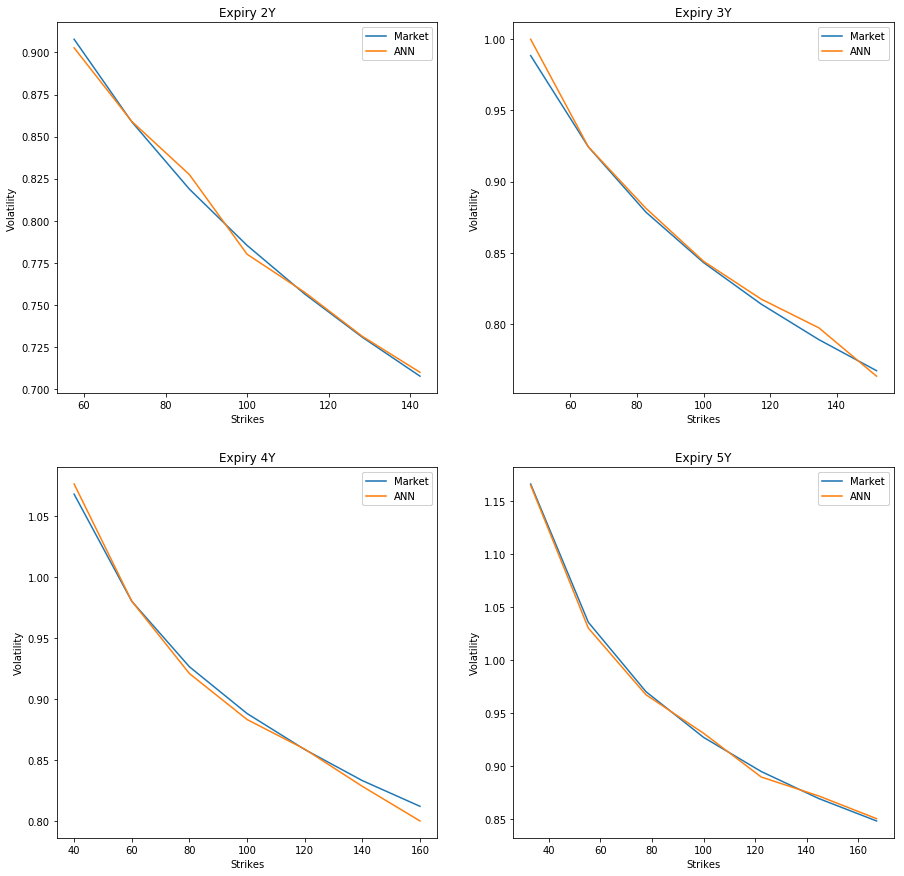

In [164]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
X = np.reshape(np.tile(Expiries,len(BaseStrikes)),(len(BaseStrikes),len(Expiries)))
Y = np.reshape(np.array(Strikes),(len(BaseStrikes),len(Expiries)))
Z_INIT = np.reshape(iv[0],(len(BaseStrikes),len(Expiries)))
Z_ANN = np.reshape(ann_iv,(len(BaseStrikes),len(Expiries)))
#print(X)
#print(Y)
#print(Z)
#surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

plt.figure(figsize=(15,15))
plt.figure(1)
current_num=221
for k in range(4):
    plt.subplot(current_num)
    line1, = plt.plot(Y[:,k+6],Z_INIT[:,k+6],label="Market")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.title("Expiry " + str(k+2) + "Y")
    line2, = plt.plot(Y[:,k+6],Z_ANN[:,k+6],label="ANN")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.gca().add_artist(plt.legend(handles=[line1,line2]))
    #plt.gca().add_artist(plt.legend(handles=[line2],loc=7))
    current_num = current_num+1

plt.show()